# Convolutional Neural Networks (CNN) with PyTorch

This part of the assignment is about implementing a Convolutional Neural Network (CNN) using PyTorch. We will be using a dataset of images of pokemon and predicting their type.

The dataset will be found in the `data` folder.

# Imports

In [151]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
# from torchvision.transforms import Lambda
from torch.utils.data.dataset import random_split


import glob
import cv2
import os

# !pip install torchsummary
from torchsummary import summary
from tqdm.notebook import tqdm

from google.colab.patches import cv2_imshow


In [152]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the dataset

We will only be predicting Water, Grass of Fire type pokemon.

In [153]:
df = pd.read_csv(fr"/content/drive/MyDrive/DL/PA2/CNN-pytorch/data/pokemon.csv")
filtered_df = df[df.Type1.isin(["Water", "Grass", "Fire"])][["Name", "Type1"]]

filtered_df = filtered_df.rename(columns=str.lower)


print("Number of Unique Pokemon: ", len(filtered_df.name.unique()))

filtered_df['label'] = filtered_df['type1'].astype('category').cat.codes
filtered_df


Number of Unique Pokemon:  245


,name,type1,label
0,bulbasaur,Grass,1
1,ivysaur,Grass,1
2,venusaur,Grass,1
3,charmander,Fire,0
4,charmeleon,Fire,0
...,...,...,...
778,bruxish,Water,2
786,tapu-bulu,Grass,1
787,tapu-fini,Water,2
797,kartana,Grass,1


# Creating dataset class

In this section we will create a dataset class, and data loaders for the training and test sets.
For this section it would help to have a look at the PyTorch documentation for the `Dataset` and `DataLoader` classes.
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

You are required to complete the implementation for the `PokemonDataset` class.

In [154]:
class PokemonDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):

        # ============ YOUR CODE HERE ============
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        # ========================================



    def __len__(self):
        # ============ YOUR CODE HERE ============
        return len(self.dataframe)
        # ========================================

    def __getitem__(self, idx):
        # ============ YOUR CODE HERE ============
        img_name_png = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0] + ".png")
        img_name_jpg = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0] + ".jpg")

        img_name = ""

        if os.path.exists(img_name_png):
            img_name = img_name_png
        elif os.path.exists(img_name_jpg):  # Try loading image with .jpg extension
            img_name = img_name_jpg
        else:
            raise FileNotFoundError(f"{img_name_png} not found for {self.dataframe.iloc[idx, 0]}")

        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = torch.tensor(self.dataframe.iloc[idx, 2], dtype=torch.long)
        label_name = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        # ========================================

        return image, label, label_name


Visualize some of the images present in the dataset, along with their labels.

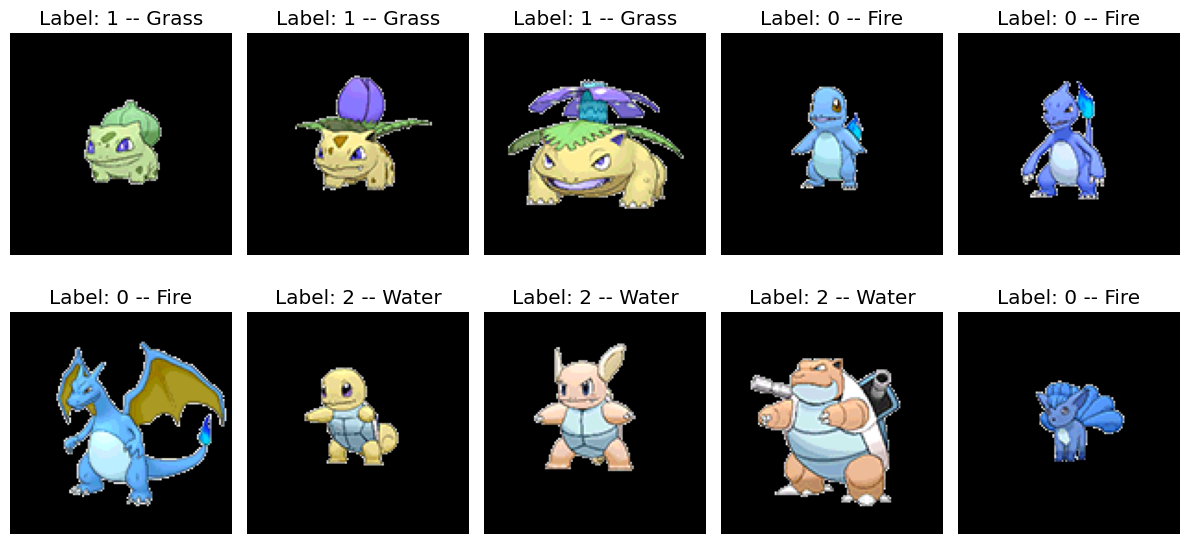

In [155]:
# Create dataset object
dataset = PokemonDataset(filtered_df, root_dir=fr"/content/drive/MyDrive/DL/PA2/CNN-pytorch/data/images")

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# Plot images and labels
for i, ax in enumerate(axes.flat):
    image, label, label_name = dataset[i]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    ax.set_title(f"Label: {label} -- {label_name}")
    ax.axis("off")

plt.tight_layout()
plt.show()

Create a train-test split and dataloaders for training data and testing data

In [156]:
BATCH_SIZE = 32

# ============ YOUR CODE HERE ==================
# Define the transforms
transform = ToTensor()

# Create instance of the dataset object with the transform defined above
dataset = PokemonDataset(
    dataframe=filtered_df,
    root_dir=fr"/content/drive/MyDrive/DL/PA2/CNN-pytorch/data/images",
    transform=transform
)

# Define the size of the train and test sets
train_size = int(0.80 * len(dataset))
test_size = len(dataset) - train_size
print("dataset len:", len(dataset))
print("train size:",train_size)
print("test size:",len(dataset) - train_size)

# Randomly split the dataset into train and test sets
train_data, test_data = random_split(dataset, [train_size, test_size])

print(train_data)
print(test_data)

# Create train and test dataloaders
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

dataset len: 245
train size: 196
test size: 49


In [157]:
# Check train_dataloader
for images, labels, _ in train_dataloader:
    print("Train Batch:")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    break

# Check test_dataloader
for images, labels, _ in test_dataloader:
    print("Test Batch:")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    break


Train Batch:
Images shape: torch.Size([32, 3, 120, 120])
Labels shape: torch.Size([32])
Test Batch:
Images shape: torch.Size([32, 3, 120, 120])
Labels shape: torch.Size([32])


# Designing CNN Architecture
In this section we will create a model class, which contains the different layers for your CNN.
For this section it would help to have a look at the PyTorch tutorial and documentation for creating a model.
https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

You are required to complete the implementation for the `PokemonModel` class.

In [158]:
import torch
import torch.nn as nn

# RESNET ABBU-3
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class PokemonModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        # Residual blocks
        self.block1 = ResidualBlock(32, 32)
        self.block2 = ResidualBlock(32, 64, stride=1)
        self.block3 = ResidualBlock(64, 128, stride=1)
        self.block4 = ResidualBlock(128, 128)

        # Average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

# Train your CNN
In this section, you are required to train your CNN on the Pokemon Dataset. You may change the `criterion`, `optimizer`, `lr` and `NUM_EPOCHS`.
You have to implement the model training for each epoch.

In [159]:
model = PokemonModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, input_size=(3, 120, 120))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 120, 120]             896
       BatchNorm2d-2         [-1, 32, 120, 120]              64
              ReLU-3         [-1, 32, 120, 120]               0
            Conv2d-4         [-1, 32, 120, 120]           9,216
       BatchNorm2d-5         [-1, 32, 120, 120]              64
              ReLU-6         [-1, 32, 120, 120]               0
            Conv2d-7         [-1, 32, 120, 120]           9,216
       BatchNorm2d-8         [-1, 32, 120, 120]              64
              ReLU-9         [-1, 32, 120, 120]               0
    ResidualBlock-10         [-1, 32, 120, 120]               0
           Conv2d-11         [-1, 64, 120, 120]          18,432
      BatchNorm2d-12         [-1, 64, 120, 120]             128
             ReLU-13         [-1, 64, 120, 120]               0
           Conv2d-14         [-1, 64, 1

In [160]:
# Set the model to training mode
model.train()

# RESNET ABBU-3 --> (without dropout 89.79%) 80-20 split
NUM_EPOCHS = 100
learning_rate = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_list = []
accuracy_list = []
test_accuracy_list = []  # To store test accuracy
best_test_accuracy = 0.0  # Track the best test accuracy
best_model_weights = None  # Store the best model weights

# Training loop
for epoch in tqdm(range(NUM_EPOCHS)):
    total_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    for images, labels, _ in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.long())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate total loss
        total_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training accuracy and loss
    epoch_loss = total_loss / len(train_dataloader)
    epoch_accuracy = correct / total * 100
    loss_list.append(epoch_loss)
    accuracy_list.append(epoch_accuracy)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels, _ in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = correct / total * 100
        test_accuracy_list.append(test_accuracy)

        # Check if current model has the best test accuracy
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_model_weights = model.state_dict()  # Save the best model weights
            torch.save(best_model_weights, fr'/content/drive/MyDrive/DL/PA2/CNN-pytorch/best_model_weights.pth')

    model.train()  # Set model back to training mode

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Loss: 1.0458, Train Accuracy: 48.47%, Test Accuracy: 48.98%
Epoch 2/100, Loss: 0.9577, Train Accuracy: 51.53%, Test Accuracy: 48.98%
Epoch 3/100, Loss: 0.8643, Train Accuracy: 57.65%, Test Accuracy: 51.02%
Epoch 4/100, Loss: 0.7750, Train Accuracy: 64.29%, Test Accuracy: 59.18%
Epoch 5/100, Loss: 0.6900, Train Accuracy: 72.45%, Test Accuracy: 69.39%
Epoch 6/100, Loss: 0.6279, Train Accuracy: 75.00%, Test Accuracy: 89.80%
Epoch 7/100, Loss: 0.7688, Train Accuracy: 75.00%, Test Accuracy: 87.76%
Epoch 8/100, Loss: 0.6178, Train Accuracy: 78.06%, Test Accuracy: 97.96%
Epoch 9/100, Loss: 0.6982, Train Accuracy: 77.55%, Test Accuracy: 95.92%
Epoch 10/100, Loss: 0.7083, Train Accuracy: 77.04%, Test Accuracy: 93.88%
Epoch 11/100, Loss: 0.6772, Train Accuracy: 77.55%, Test Accuracy: 93.88%
Epoch 12/100, Loss: 0.5882, Train Accuracy: 75.51%, Test Accuracy: 95.92%
Epoch 13/100, Loss: 0.5757, Train Accuracy: 77.55%, Test Accuracy: 91.84%
Epoch 14/100, Loss: 0.6173, Train Accuracy: 78.

In [161]:
model.load_state_dict(best_model_weights)
print("Best Test Accuracy:", best_test_accuracy)

Best Test Accuracy: 97.95918367346938


Visualize performance on training data

/HUO


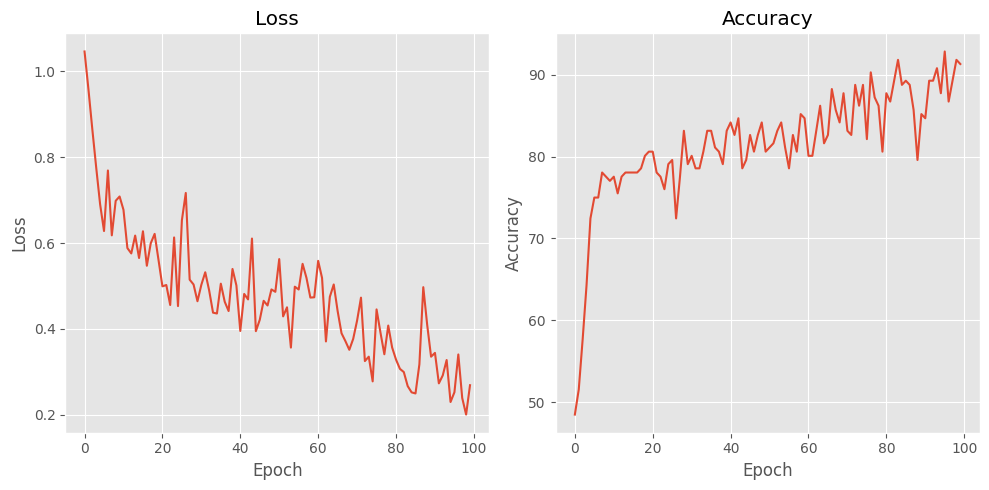

In [162]:
if torch.cuda.is_available():
  print("/HUO")
plt.style.use("ggplot")
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot loss
axes[0].plot(loss_list)
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# Plot accuracy
axes[1].plot(accuracy_list)
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# Evaluate your CNN
In this section, you will set your model in evaluation mode and evaluate it on your test data.
You have to implement the evaluation loop and report the test accuracy.

In [163]:

best_model_weights_path = "/content/drive/MyDrive/DL/PA2/CNN-pytorch/best_model_weights.pth"
best_model = PokemonModel()
best_model.load_state_dict(torch.load(best_model_weights_path))

# Set the model to evaluation mode
best_model.to(device)
best_model.eval()

# Evaluate the model on the test dataset
correct = 0
total = 0
with torch.no_grad():
    for images, labels, _ in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate test accuracy
test_accuracy = correct / total * 100
print(f"Test Accuracy using best weights: {test_accuracy:.2f}%")

Test Accuracy using best weights: 97.96%


Visualize performance on test data

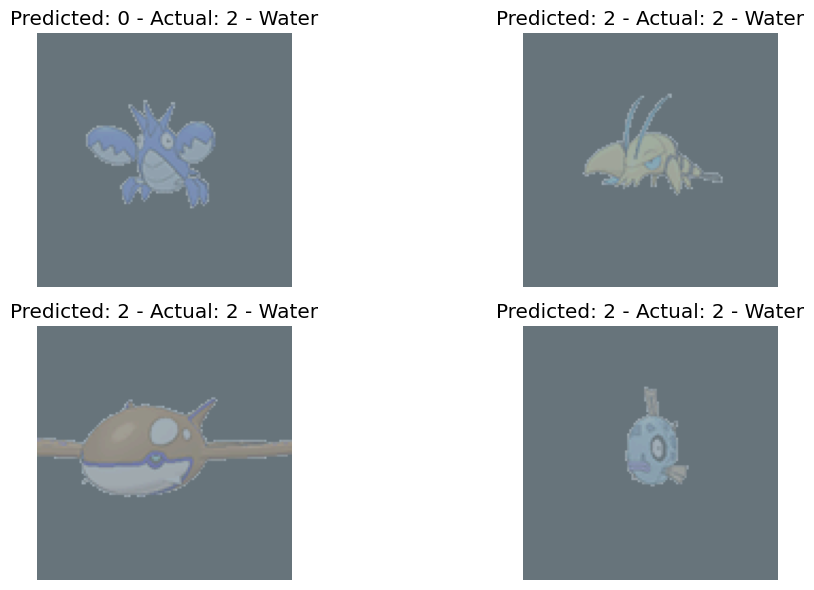

In [164]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Iterate over the first 4 images in the test dataset
for i, (image, label, label_name) in enumerate(list(train_data)[0:4]):
    # Move the image to the device
    image = image.to(device)

    # Forward pass
    output = best_model(image.unsqueeze(0))

    # Calculate the predicted label
    _, predicted_label = torch.max(output, 1)

    # Convert the image tensor to numpy array
    image = image.permute(1, 2, 0).cpu().numpy()

    # Multiply image by std and add mean
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image *= 255
    image = image.astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Plot the image and predicted label
    ax = axes[i // 2, i % 2]
    ax.imshow(image)
    ax.set_title(f"Predicted: {predicted_label.item()} - Actual: {label} - {label_name}")
    ax.axis("off")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Exporting

In [165]:
!pip install onnx -q

model = PokemonModel()
model.load_state_dict(torch.load("/content/drive/MyDrive/DL/PA2/CNN-pytorch/best_model_weights.pth", map_location=torch.device('cpu')))
model.eval()

dummy_input = torch.randn(1, 3, 120, 120)  # input size is (batch_size, channels, height, width)

# Export the model to ONNX format
onnx_path = "/content/drive/MyDrive/DL/PA2/CNN-pytorch/best_model.onnx"
torch.onnx.export(model, dummy_input, onnx_path, verbose=True)
print("EXPORTING DONE!!")

EXPORTING DONE!!
